In [21]:
import pysindy as ps
import numpy as np
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
%matplotlib inline



# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [22]:
# Function definitions.

def timeseriesIntoSupervised(timeseriesArray,nin=1,nout=1):

  # This function converts time series into a data format that is suitible for supervised training.

  def hankelize(array,dim):

    iterNumber = len(array) - dim + 1
  
    hankelizedMatrix = np.zeros((1,dim))
    

    for ix in range(iterNumber):
      
      
      arrayToStack = array[ix:ix+dim]
      hankelizedMatrix = np.vstack((hankelizedMatrix,arrayToStack))


    hankelizedMatrix = hankelizedMatrix[1:]


    return hankelizedMatrix


  winSize = nin + nout
  featNumber = timeseriesArray.shape[0]
  
  XList = []
  yList = []

  for ix in range(featNumber):
    
    
    timeSeriesFeature = timeseriesArray[ix]
    
    hankelizedFeature = hankelize(timeSeriesFeature,winSize)
    
    
    XFeat = hankelizedFeature[:,0:nin]
    
    yFeat = hankelizedFeature[:,nin:winSize]
    
    
    

    XList.append(XFeat)
    yList.append(yFeat)

  
  
  
  X = np.dstack(XList).reshape(-1,nin,featNumber)
  y = np.dstack(yList).reshape(-1,nout,featNumber)

  

  return X,y


def plotFromHistory(historyObject):

  varList =  list(historyObject.history.keys())
  

  for e in varList:
    
    fig = plt.figure(figsize=(5,5))
    listToPlot = historyObject.history[e]
    plt.plot(listToPlot,color='b')
    plt.xlabel('Epoch')
    plt.ylabel(e)
    plt.title(f'Plot of {e}')
    plt.grid()


  

In [23]:
# Generating lorentz training and test data.

dt = 0.01

t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])

t_test = np.arange(10, 14, dt)
t_test_span = (t_test[0], t_test[-1])

x0_train = [-8, -2, 10]


x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T

x_test = solve_ivp(lorenz, t_test_span,
                    x_train[-1], t_eval=t_test, **integrator_keywords).y.T


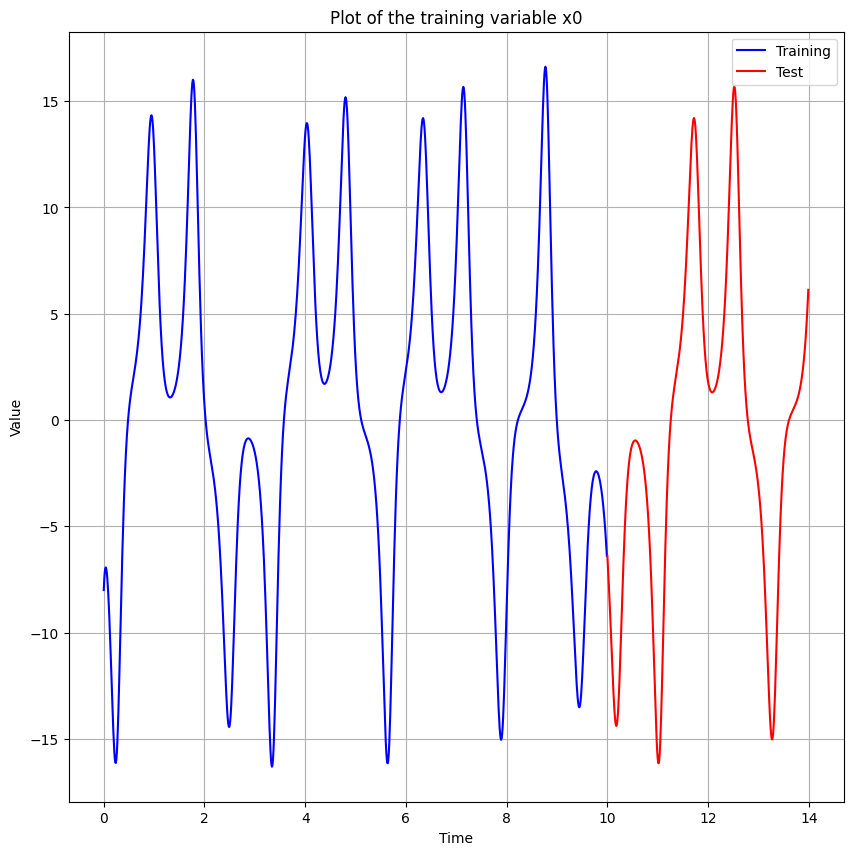

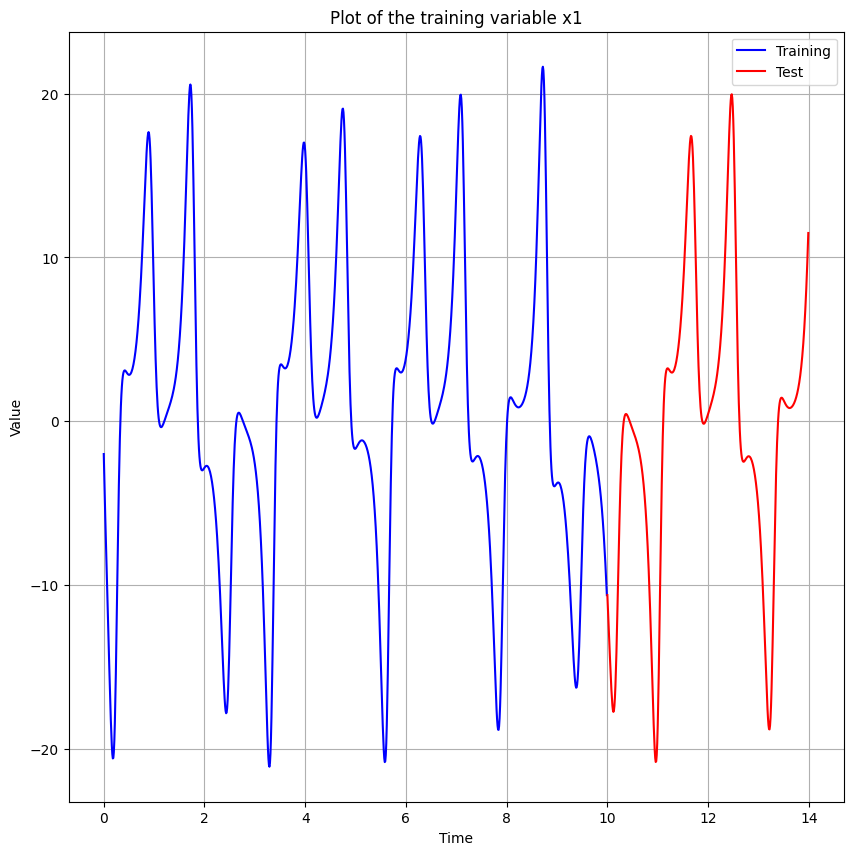

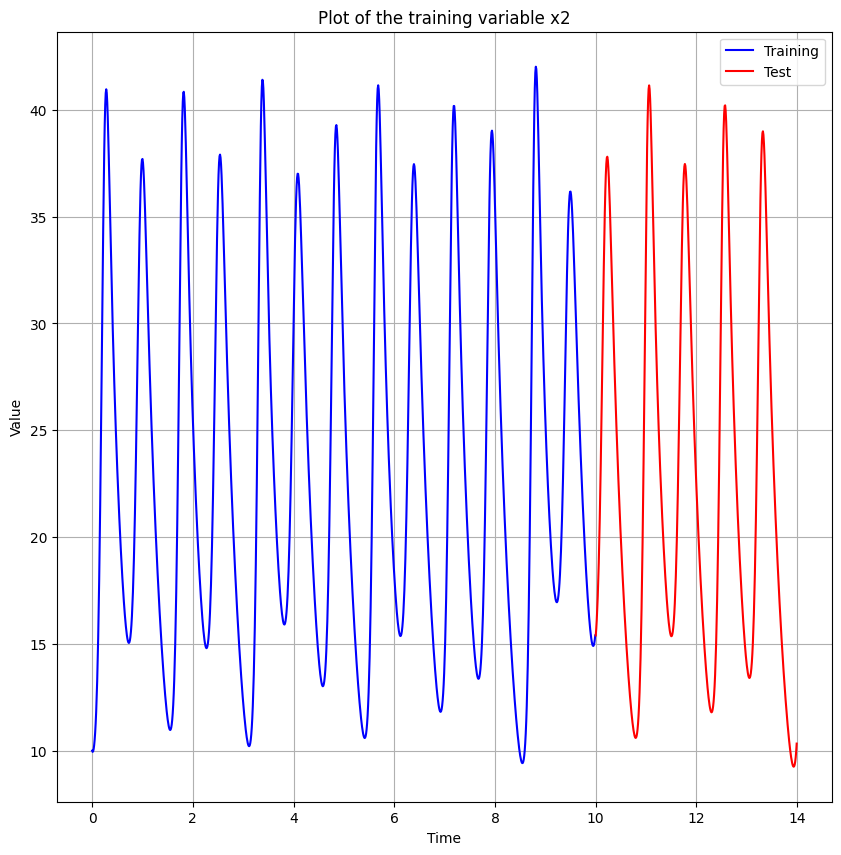

In [24]:
# Plotting training and test data.

titleStart = 'Plot of the training variable x' 

for ix in range(3):
    fig = plt.figure(figsize=(10,10))
    plt.plot(t_train,x_train[:,ix],'b',label='Training')
    plt.plot(t_test,x_test[:,ix],'r',label='Test')
    plt.title(titleStart+str(ix))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()


In [25]:
x_train.shape

(1000, 3)

Preprocessing.

In [26]:
# Converting into supervised machine learning problem.

nout = 5
nin = 10

XTrainLSTM, yTrainLSTM = timeseriesIntoSupervised(np.transpose(x_train),nin,nout)
XTestLSTM, yTestLSTM = timeseriesIntoSupervised(np.transpose(x_test),nin,nout)



In [27]:
# The shapes.
print(f'Shape of XTrain:{XTrainLSTM.shape}\nShape of XTest:{XTestLSTM.shape}\nShape of yTrain:{yTrainLSTM.shape}\nShape of yTest:{yTestLSTM.shape}')

Shape of XTrain:(986, 10, 3)
Shape of XTest:(386, 10, 3)
Shape of yTrain:(986, 5, 3)
Shape of yTest:(386, 5, 3)


In [28]:
# Reshaping for the correct form.

XTrainLSTM = tf.keras.layers.Flatten()(XTrainLSTM)
XTestLSTM = tf.keras.layers.Flatten()(XTestLSTM)
yTrainLSTM = tf.keras.layers.Flatten()(yTrainLSTM)
yTestLSTM= tf.keras.layers.Flatten()(yTestLSTM)



In [29]:
# The new shapes.
print(f'Shape of XTrain:{XTrainLSTM.shape}\nShape of XTest:{XTestLSTM.shape}\nShape of yTrain:{yTrainLSTM.shape}\nShape of yTest:{yTestLSTM.shape}')

Shape of XTrain:(986, 30)
Shape of XTest:(386, 30)
Shape of yTrain:(986, 15)
Shape of yTest:(386, 15)


Building the model.

In [30]:
# Building the LSTM model.

inputs = tf.keras.Input(shape=(XTrainLSTM.shape[1],1))
lstm1 = LSTM(units=10)(inputs) # The units hyperparameter selected as 10.
pred = Dense(units=yTrainLSTM.shape[1])(lstm1) # The last layer is a dense network.

modelLSTM = tf.keras.Model(inputs=inputs, outputs=pred)
modelLSTM.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 15)                165       
                                                                 
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model

modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss= tf.keras.losses.MeanSquaredError(),
                  metrics= tf.keras.metrics.MeanSquaredError()
                  )

history = modelLSTM.fit(x=XTrainLSTM,y=yTrainLSTM,
              batch_size=16,
              shuffle=False,
              epochs=1000,
              validation_split=0.2,
              )

# modelLSTM.save('C:/Users/olyaa/Desktop/AstroResearch/models/modelBuffer.keras')

In [ ]:
# modelLSTM = tf.keras.saving.load_model(
#     'C:/Users/olyaa/Desktop/AstroResearch/models/modelBuffer.keras', custom_objects=None, compile=True, safe_mode=True
# )

Prediction on the Test Set

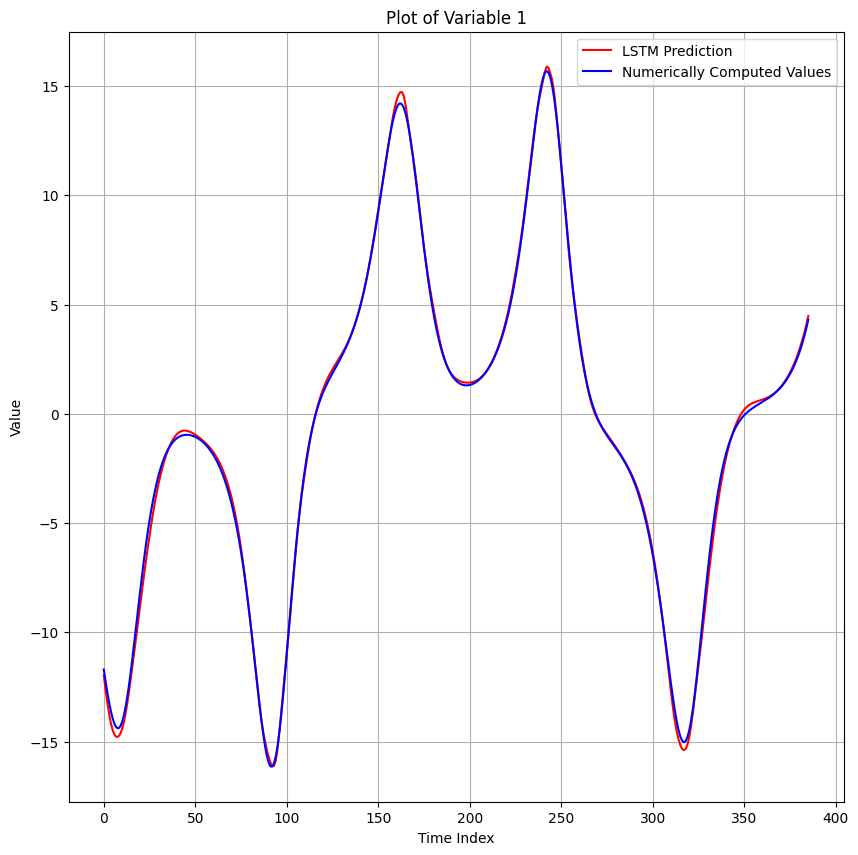

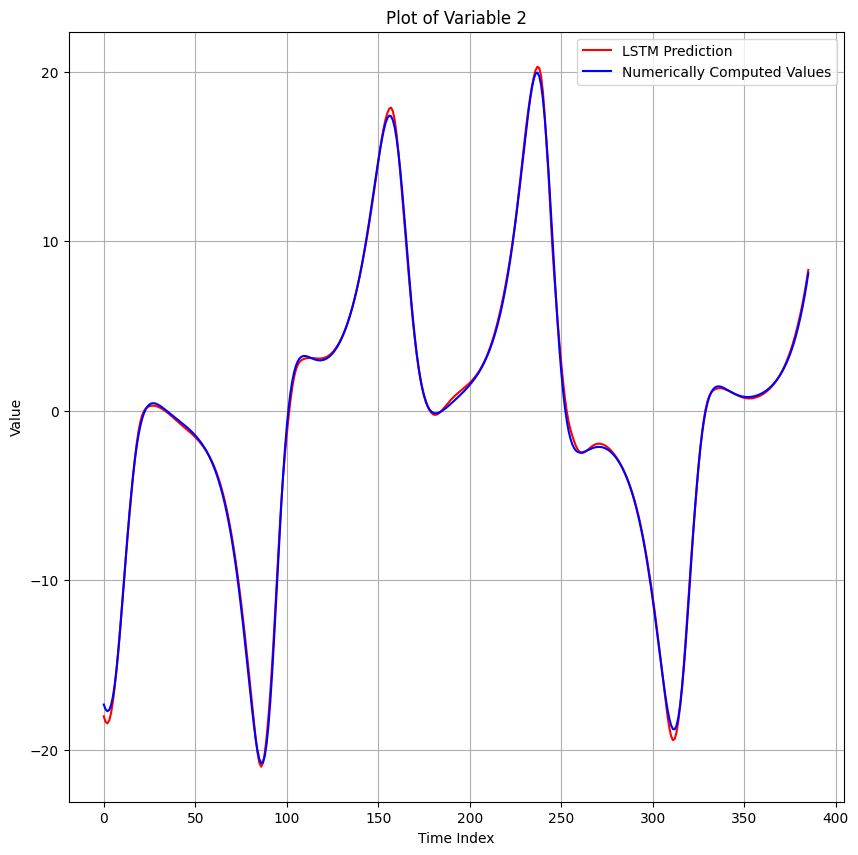

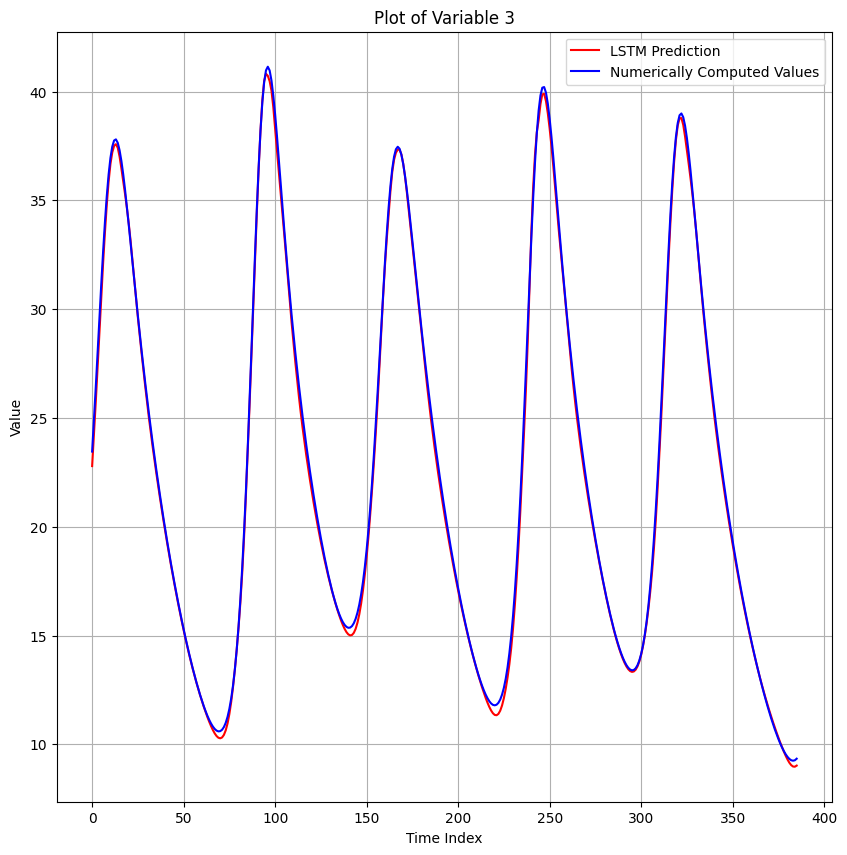

In [32]:


# # Pred Algo No1 (Too Unstable)

# yTestLSTMPred = np.zeros(shape=yTestLSTM.shape)
# XBuffer = XTestLSTM[0,:,:]

# yTrainLSTMPred = np.zeros(shape=yTrainLSTM.shape)
# yTrainLSTMPred = modelLSTM.predict(XTrainLSTM,batch_size=None,verbose=0)

# for ix in range(yTestLSTM.shape[0]):

#      yTestLSTMPred[ix,:] = modelLSTM.predict(XBuffer.reshape(1,1,3),batch_size=None,verbose=0)
#      XBuffer = yTestLSTMPred[ix,:]
#      print(f'{ix}/{yTestLSTM.shape[0]}')




# Pred Algo No2


yTestLSTMPred = modelLSTM.predict(XTestLSTM,batch_size=None,verbose=0)

yTestLSTMPred = np.reshape(yTestLSTMPred,(-1,nout,3))
yTestLSTM = np.reshape(yTestLSTM,(-1,nout,3))




# Comparing the predictions to the numerical simulation.

for ix in range(3):

    predArray = yTestLSTMPred[:,0,ix]
    trueArray = yTestLSTM[:,0,ix]
     
    fig = plt.figure(figsize=(10,10))
    plt.plot(predArray,color='r',label='LSTM Prediction')
    plt.plot(trueArray,color='b',label='Numerically Computed Values')
    plt.title(f'Plot of Variable {ix+1}')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()



